# Trong đại dịch Covid-19 có nguồn gốc từ Wuhan, Trung Quốc đã làm ảnh hưởng tới cuộc sống của nhân loại, cướp đi sinh mạng của ít nhất 200.000 người vô tội và sẽ còn tiếp tục tăng trong thời gian tới.
## Để phục vụ công tác chẩn đoán bệnh, các nhà khoa học đã tìm cách áp dụng trí thông minh nhân tạo vào trong việc xử lí và chẩn đoán ảnh CT và X quang chụp phổi để đánh giá tổn thương và phân loại viêm phổi do các nguyên nhân khác nhau, trong đó có Covid-19.
## Trong bài này, mình sử dụng dataset tại đây: https://covidresearch.ai/datasets/dataset?id=2. Theo như tìm hiểu về cơ sở dữ liệu này, có lẽ nó được tiếp thu từ 2 nghiên cứu trước đó là bài báo này https://arxiv.org/abs/2003.11597 (địa chỉ github: https://github.com/ieee8023/covid-chestxray-dataset) và bài báo này https://arxiv.org/abs/2003.09871 (https://github.com/lindawangg/COVID-Net).
## Gần đây có bài báo công bố sử dụng mạng EfficientNet (bài báo về mạng tại đây https://arxiv.org/pdf/1905.11946.pdf) để chẩn đoán dataset này cho kết quả có độ nhạy và độ đặc hiệu cao hơn hẳn các kết quả trước đó. Các bạn có thể tham khảo bài báo này tại đây: https://arxiv.org/pdf/2004.05717.pdf. Kết quả bài báo chỉ ra rằng họ đã thêm vào mạng EfficientNet_B0 một số lớp để cải thiện khả năng phân loại. Tuy nhiên bài báo sử dụng Framework là Keras, còn trong bài lặp lại thí nghiệm này, mình sử dụng Framework là PyTorch với đóng góp rất lớn của anh Ross Wightman khi xây dựng các mạng thần kinh tích chập sâu cho công việc phân loại ảnh (các bạn có thể tham khảo code tại đây https://github.com/rwightman/pytorch-image-models).
### Bên cạnh việc sử dụng Framework khác với bài báo gốc, mình cũng có 1 số thay đổi như mình dùng hàm tối ưu là SGD thay vì ADAM, và mình bổ thêm kĩ thuật Augmentation (ở đây mình dùng thêm kĩ thuật RandAugmentation tại bài báo này https://arxiv.org/abs/1909.13719) để nâng cao độ chính xác.
### Mình cũng đã thử huấn luyện dataset này với các mạng khác nhau, tuy nhiên kết quả phân loại có lẽ vẫn hiệu quả nhất với mạng EfficientNet_B0.
### Tuy nhiên, để mô hình này có thể sử dụng trong thực tiễn, chắc chắn cần phải tiến hành internal và external validity qua nhiều bước khác nhau. Thêm vào đó, chúng ta hoàn toàn có thể nghĩ đến kĩ thuật ensemble voting để tăng tính chính xác cho công cụ chẩn đoán!
# For fun, mình xây dựng thử nền tảng web dùng cho chẩn đoán các ảnh X quang vùng ngực xem bệnh nhân có nhiễm Covid-19 hay không. Các bạn có thể tham khảo tại địa chỉ github của minh [https://github.com/linhduongtuan/Covid-19_Xray_Classifier/]

In [1]:
import os
import re
import PIL
import sys
import json
import time
import timm
import math
import copy
import torch
import pickle
import logging
import fnmatch
import argparse
import torchvision
import numpy as np
%matplotlib inline
import pandas as pd
import seaborn as sns
import torch.nn as nn
from PIL import Image
from pathlib import Path
from copy import deepcopy
from sklearn import metrics
import torch.optim as optim
from datetime import datetime
from torchvision import models
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.utils.data as data
from torch.autograd import Variable
from tqdm import tqdm, tqdm_notebook
from torch.optim import lr_scheduler
import torch.utils.model_zoo as model_zoo
from timm.models.layers.activations import *
%config InlineBackend.figure_format = 'retina'
from collections import OrderedDict, defaultdict
from torchvision import transforms, models, datasets
from torch.utils.data.sampler import SubsetRandomSampler
from randaugment import RandAugment, ImageNetPolicy, Cutout
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report

In [2]:
data_dir = '/home/linh/Downloads/Covid-19'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/test'

# Define your transforms for the training and testing sets
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        RandAugment(),
        ImageNetPolicy(),
        Cutout(size=16),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ])
}

# Load the datasets with ImageFolder
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
batch_size = 100
data_loader = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=4, pin_memory = True)
              for x in ['train', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}

class_names = image_datasets['train'].classes
print(class_names)
print(dataset_sizes)
print(device)

### we get the class_to_index in the data_Set but what we really need is the cat_to_names  so we will create
_ = image_datasets['train'].class_to_idx
cat_to_name = {_[i]: i for i in list(_.keys())}
print(cat_to_name)
    
# Run this to test the data loader
images, labels = next(iter(data_loader['test']))
images.size()

['COVID-19', 'normal', 'pneumonia']
{'train': 13511, 'test': 1489}
cuda:0
{0: 'COVID-19', 1: 'normal', 2: 'pneumonia'}


torch.Size([100, 3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

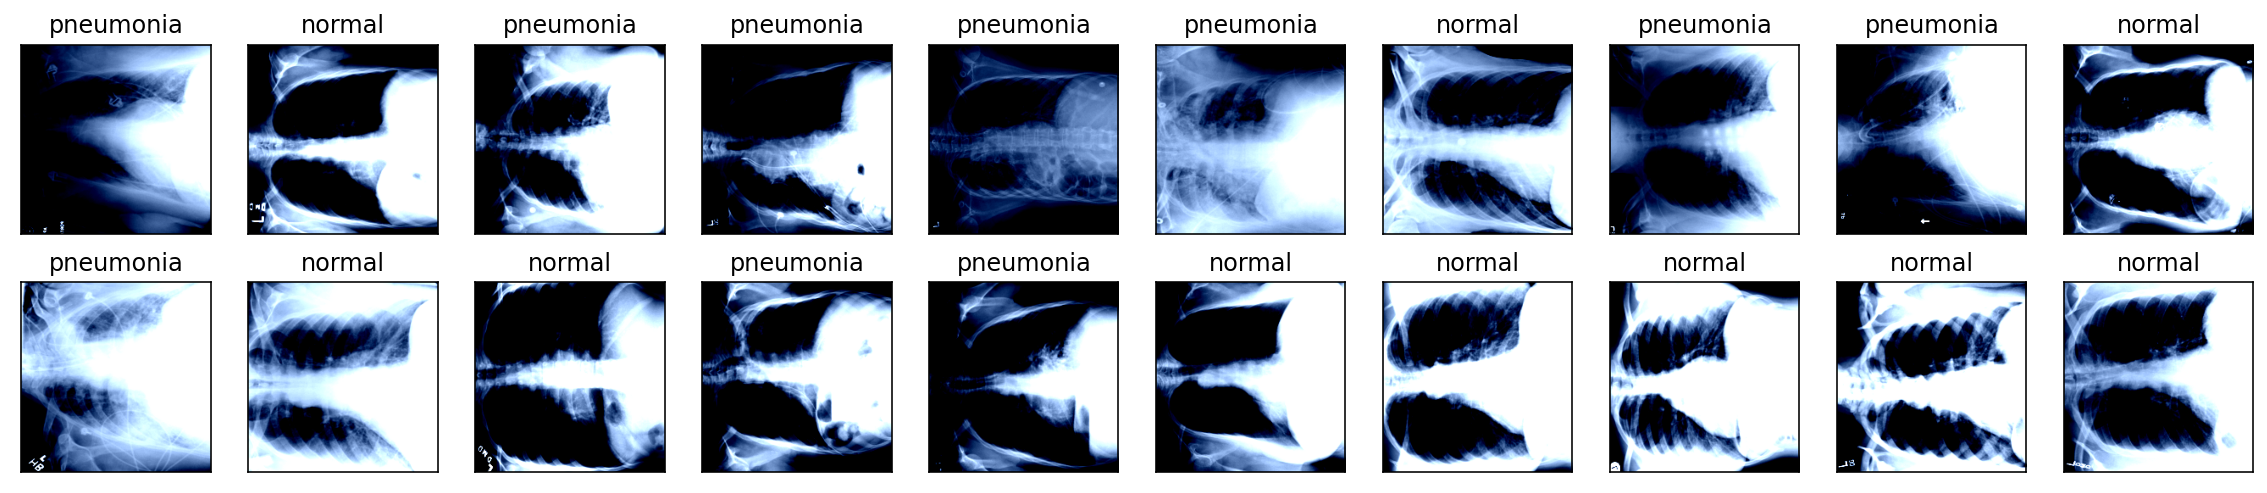

In [3]:
def showimage(data_loader, number_images, cat_to_name):
    dataiter = iter(data_loader)
    images, labels = dataiter.next()
    images = images.numpy() # convert images to numpy for display
    # plot the images in the batch, along with the corresponding labels
    fig = plt.figure(figsize=(number_images, 4))
    for idx in np.arange(number_images):
        ax = fig.add_subplot(2, number_images/2, idx+1, xticks=[], yticks=[])
        img = np.transpose(images[idx])
        plt.imshow(img)
        ax.set_title(cat_to_name[labels.tolist()[idx]])
        
#### to show some  images
showimage(data_loader['test'], 20, cat_to_name)

In [3]:
#model = models.resnet50(pretrained=True)
#model = timm.create_model('resnet50', pretrained=True)
model = timm.create_model('efficientnet_b0', pretrained=True)
#model.fc #show fully connected layer for ResNet family
model.classifier #show the classifier layer (fully connected layer) for EfficientNets

Linear(in_features=1280, out_features=1000, bias=True)

In [4]:
# Create classifier
for param in model.parameters():
    param.requires_grad = True
# define `classifier` for ResNet
# Otherwise, define `fc` for EfficientNet family 
#because the definition of the full connection/classifier of 2 CNN families is differnt
fc = nn.Sequential(OrderedDict([('fc1', nn.Linear(2048, 1000, bias=True)),
							     ('BN1', nn.BatchNorm2d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
								 ('dropout1', nn.Dropout(0.7)),
                                 ('fc2', nn.Linear(1000, 512)),
								 ('BN2', nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
								 ('swish1', Swish()),
								 ('dropout2', nn.Dropout(0.5)),
								 ('fc3', nn.Linear(512, 128)),
								 ('BN3', nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
							     ('swish2', Swish()),
								 ('fc4', nn.Linear(128, 3)),
								 ('output', nn.Softmax(dim=1))
							 ]))
# connect base model (EfficientNet_B0) with modified classifier layer
model.fc = fc
criterion = nn.CrossEntropyLoss()
#optimizer = Nadam(model.parameters(), lr=0.001)
#optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
optimizer = optim.SGD(model.parameters(), 
                      lr=0.01,momentum=0.9,
                      nesterov=True,
                      weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
#show our model architechture and send to GPU
model.to(device)

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): Swish()
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): Swish()
        (se): SqueezeExcite(
          (avg_pool): AdaptiveAvgPool2d(output_size=1)
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): Swish()
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
 

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=200, checkpoint = None):
    since = time.time()

    if checkpoint is None:
        best_model_wts = copy.deepcopy(model.state_dict())
        best_loss = math.inf
        best_acc = 0.
    else:
        print(f'Val loss: {checkpoint["best_val_loss"]}, Val accuracy: {checkpoint["best_val_accuracy"]}')
        model.load_state_dict(checkpoint['model_state_dict'])
        best_model_wts = copy.deepcopy(model.state_dict())
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        best_loss = checkpoint['best_val_loss']
        best_acc = checkpoint['best_val_accuracy']

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for i, (inputs, labels) in enumerate(data_loader[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()
                
                if i % 1000 == 999:
                    print('[%d, %d] loss: %.8f' % 
                          (epoch + 1, i, running_loss / (i * inputs.size(0))))

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':                
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':                
                scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.8f} Acc: {:.8f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_loss < best_loss:
                print(f'New best model found!')
                print(f'New record loss: {epoch_loss}, previous record loss: {best_loss}')
                best_loss = epoch_loss
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save({'model_state_dict': model.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'best_val_loss': best_loss,
                            'best_val_accuracy': best_acc,
                            'scheduler_state_dict' : scheduler.state_dict(),
                            }, 
                            CHECK_POINT_PATH
                            )
                print(f'New record loss is SAVED: {epoch_loss}')

        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.8f} Best val loss: {:.8f}'.format(best_acc, best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_loss, best_acc

In [7]:
CHECK_POINT_PATH = '/home/linh/Downloads/Covid-19/weights/EfficientNet_B0_Covid-19.pth'
try:
    checkpoint = torch.load(CHECK_POINT_PATH)
    print("checkpoint loaded")
except:
    checkpoint = None
    print("checkpoint not found")
if checkpoint == None:
    CHECK_POINT_PATH = CHECK_POINT_PATH
model, best_val_loss, best_val_acc = train_model(model,
                                                 criterion,
                                                 optimizer,
                                                 scheduler,
                                                 num_epochs = 100,
                                                 checkpoint = torch.load(CHECK_POINT_PATH)
                                                 ) 
                                                
torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss,
            'best_val_accuracy': best_val_acc,
            'scheduler_state_dict': scheduler.state_dict(),
            }, CHECK_POINT_PATH)

checkpoint loaded
Val loss: 0.171456889108654, Val accuracy: 0.9415715245130961
Epoch 0/99
----------
train Loss: 0.27257772 Acc: 0.89416031
test Loss: 0.15811775 Acc: 0.94291471
New best model found!
New record loss: 0.1581177499728206, previous record loss: 0.171456889108654
New record loss is SAVED: 0.1581177499728206

Epoch 1/99
----------
train Loss: 0.26352881 Acc: 0.90074754
test Loss: 0.18595937 Acc: 0.93216924

Epoch 2/99
----------
train Loss: 0.25787086 Acc: 0.90370809
test Loss: 0.15858672 Acc: 0.94157152

Epoch 3/99
----------
train Loss: 0.24595694 Acc: 0.90785286
test Loss: 0.16293945 Acc: 0.94089993

Epoch 4/99
----------
train Loss: 0.24436598 Acc: 0.90518837
test Loss: 0.17971332 Acc: 0.94157152

Epoch 5/99
----------
train Loss: 0.23678295 Acc: 0.90999926
test Loss: 0.17018649 Acc: 0.93552720

Epoch 6/99
----------
train Loss: 0.23742557 Acc: 0.90829694
test Loss: 0.14518083 Acc: 0.95231699
New best model found!
New record loss: 0.14518083418332306, previous record l

In [8]:
model.class_to_idx = image_datasets['train'].class_to_idx
model.idx_to_class = {
    idx: class_
    for class_, idx in model.class_to_idx.items()
}
list(model.class_to_idx.items())

[('COVID-19', 0), ('normal', 1), ('pneumonia', 2)]

In [9]:
list(model.idx_to_class.items())

[(0, 'COVID-19'), (1, 'normal'), (2, 'pneumonia')]

In [5]:
CHECK_POINT_PATH = '/home/linh/Downloads/Covid-19/weights/EfficientNet_B0_Covid-19.pth'
try:
    checkpoint = torch.load(CHECK_POINT_PATH)
    print("checkpoint loaded")
except:
    checkpoint = None
    print("checkpoint not found")

def load_model(path):                                
  model.load_state_dict(checkpoint['model_state_dict'])
  best_model_wts = copy.deepcopy(model.state_dict())
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
  best_loss = checkpoint['best_val_loss']
  best_acc = checkpoint['best_val_accuracy']
load_model(CHECK_POINT_PATH)  

since = time.time()
model.eval()
y_test = []
y_pred = []
for images, labels in data_loader['test']:
    images = Variable(images.cuda())
    labels = Variable(labels.cuda())
    outputs = model(images)
    _, predictions = outputs.max(1)
    
    y_test.append(labels.data.cpu().numpy())
    y_pred.append(predictions.data.cpu().numpy())
    
y_test = np.concatenate(y_test)
y_pred = np.concatenate(y_pred)
pd.DataFrame({'true_label':y_test,'predicted_label':y_pred}).to_csv('/home/linh/Downloads/Covid-19/results/Modified_EfficienNet_B0_Covid-19_Test.csv',index=False)

time_elapsed = time.time() - since

print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

sns.heatmap(confusion_matrix(y_test, y_pred))
accuracy_score(y_test, y_pred)

report = classification_report(y_test, y_pred)
print(report)

checkpoint loaded


RuntimeError: CUDA out of memory. Tried to allocate 154.00 MiB (GPU 0; 10.91 GiB total capacity; 8.40 GiB already allocated; 86.25 MiB free; 8.48 GiB reserved in total by PyTorch)

In [ ]:
since = time.time()
model.eval()
y_test = []
y_pred = []
for images, labels in data_loader['train']:
    images = Variable(images.cuda())
    labels = Variable(labels.cuda())
    outputs = model(images)
    _, predictions = outputs.max(1)
    
    y_test.append(labels.data.cpu().numpy())
    y_pred.append(predictions.data.cpu().numpy())
    
y_test = np.concatenate(y_test)
y_pred = np.concatenate(y_pred)
pd.DataFrame({'true_label':y_test,'predicted_label':y_pred}).to_csv('/home/linh/Downloads/Covid-19/results/Modifier_EfficienNet_B0_Covid-19_Train.csv',index=False)

time_elapsed = time.time() - since

print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

sns.heatmap(confusion_matrix(y_test, y_pred))
accuracy_score(y_test, y_pred)

report = classification_report(y_test, y_pred)
print(report)